<a href="https://colab.research.google.com/github/Rahulraj31/Transfer_Learning/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning in image classification
In this notebook we will use transfer learning and take pre-trained model from google's Tensorflow Hub and re-train that on flowers dataset. Using pre-trained model saves lot of time and computational budget for new classification problem at hand

In [ ]:
# Install tensorflow_hub using pip install tensorflow_hub firs
#pip install tensorflow_hub

In [ ]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers,losses
from tensorflow.keras.models import Sequential


**Make predictions using ready made model (without any training)**

In [ ]:
IMAGE_SHAPE=(224,224)
classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,)) #adding 3 for RGB channel
])

In [ ]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

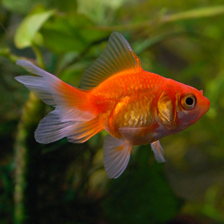

In [ ]:
gold_fish = Image.open("/content/download.png").resize(IMAGE_SHAPE)
gold_fish

In [ ]:
#Scaling
gold_fish =np.array(gold_fish)/255.0
gold_fish

array([[[0.28235294, 0.33333333, 0.07058824],
        [0.31372549, 0.37254902, 0.09019608],
        [0.34901961, 0.41960784, 0.11764706],
        ...,
        [0.32941176, 0.39215686, 0.00392157],
        [0.32156863, 0.38431373, 0.00392157],
        [0.30980392, 0.36862745, 0.        ]],

       [[0.28627451, 0.33333333, 0.08235294],
        [0.3254902 , 0.38039216, 0.10980392],
        [0.35294118, 0.42352941, 0.12941176],
        ...,
        [0.32156863, 0.38039216, 0.00392157],
        [0.31372549, 0.37254902, 0.00392157],
        [0.30196078, 0.36078431, 0.        ]],

       [[0.28627451, 0.33333333, 0.08627451],
        [0.31372549, 0.36862745, 0.10196078],
        [0.34509804, 0.41568627, 0.12941176],
        ...,
        [0.31764706, 0.37647059, 0.00392157],
        [0.30980392, 0.36862745, 0.00784314],
        [0.29803922, 0.35686275, 0.00392157]],

       ...,

       [[0.05490196, 0.10980392, 0.01568627],
        [0.05098039, 0.11372549, 0.01960784],
        [0.05098039, 0

In [ ]:
# As predict function cannot work on single input we will add one dimension of our photo
gold_fish[np.newaxis, ...].shape 

(1, 224, 224, 3)

In [ ]:
result=classifier.predict(gold_fish[np.newaxis, ...])

Now this array contains the probability  of all 1000 classes to which our image can be classified.

In [ ]:
result.shape   # 1 means 1 inputed row and 1001 means 1000 classes 

(1, 1001)

In [ ]:
predicted_label_index =np.argmax(result)
print("Index The label Class is ",predicted_label_index)

Index The label Class is  2


The mapping from indices to class labels can be found in the file at [download.tensorflow.org/data/ImageNetLabels.txt](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt)
<br>
**So we render it directly without downloading using keras**

In [ ]:
tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')



16384/10484 [==============================================] - 0s 0us/step


'/root/.keras/datasets/ImageNetLabels.txt'

In [ ]:
image_labels = []
with open("/root/.keras/datasets/ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [ ]:
image_labels[predicted_label_index]

'goldfish'

**And there we have it goldfish**


# Load flowers dataset

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

228818944/228813984 [==============================] - 2s 0us/step


In [ ]:
dataset_url

'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'

In [ ]:
import pathlib                               
data_dir = pathlib.Path(data_dir)                 #make windows/PosixPath path object
data_dir

PosixPath('datasets/flower_photos')

In [ ]:
list(data_dir.glob('*/*.jpg'))[:5]  #stores path of each image 

[PosixPath('datasets/flower_photos/sunflowers/26254755_1bfc494ef1_n.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/164668737_aeab0cb55e_n.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/4933230247_a0432f01da.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/21349789961_18ba1af5b7_n.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/9399711558_7cb9547cd3_n.jpg')]

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [ ]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/8642943283_47e44d049d_m.jpg'),
 PosixPath('datasets/flower_photos/roses/9702378513_229a96b754_m.jpg'),
 PosixPath('datasets/flower_photos/roses/5578760521_e54aca6bed_n.jpg'),
 PosixPath('datasets/flower_photos/roses/16051111039_0f0626a241_n.jpg'),
 PosixPath('datasets/flower_photos/roses/5497730366_44d758d8f5.jpg')]

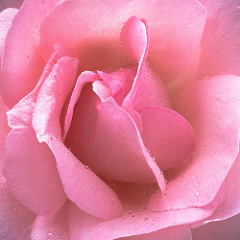

In [ ]:
Image.open(str(roses[1]))

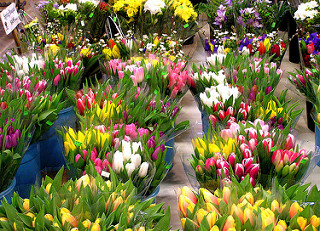

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
Image.open(str(tulips[0]))

# Read flowers images from disk/stored folder into numpy array using opencv

In [ ]:
#making dictinary 
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [ ]:
#showing stored data
flowers_images_dict["roses"][:5]

[PosixPath('datasets/flower_photos/roses/8642943283_47e44d049d_m.jpg'),
 PosixPath('datasets/flower_photos/roses/9702378513_229a96b754_m.jpg'),
 PosixPath('datasets/flower_photos/roses/5578760521_e54aca6bed_n.jpg'),
 PosixPath('datasets/flower_photos/roses/16051111039_0f0626a241_n.jpg'),
 PosixPath('datasets/flower_photos/roses/5497730366_44d758d8f5.jpg')]

In [ ]:
#Making dictinary for storing there labels
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [ ]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/8642943283_47e44d049d_m.jpg'

In [ ]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [ ]:
img.shape

(240, 240, 3)

In [ ]:
# reshaping it to make dimensions suitable for our pre trained model
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [ ]:
# Making Dataset

X, y = [], []

for flower_name,images in flowers_images_dict.items():#returns key , path for each record
   for image in images:
     img=cv2.imread(str(image))
     resize_img=cv2.resize(img,(224,224))
     X.append(resize_img)
     y.append(flowers_labels_dict[flower_name])


In [ ]:
# type casting X,y to numpy array
X = np.array(X)
y = np.array(y)

# Train test split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
# Scaling the image 
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

# Make prediction using pre-trained model on new flowers dataset

In [ ]:
X[0].shape

(224, 224, 3)

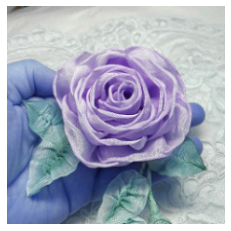

In [ ]:

plt.axis('off')
plt.imshow(X[0])

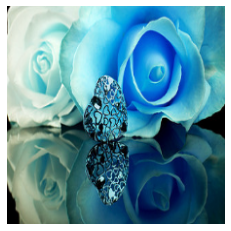

In [ ]:
plt.axis('off')
plt.imshow(X[2])

In [ ]:
prediction =classifier.predict(np.array([X[0],X[1],X[2]]))
prediction =np.argmax(prediction,axis=1)
prediction

array([722, 795, 722])

These are labels of class compare it with imageclass .txt file

In [ ]:
print(image_labels[722])
print(image_labels[795])

pillow
shower curtain


**Now our model has only Daisy class for flowers that is why it is giving these results for roses**\

# Now we will Retrain this model

we do it using feature extractor model of mobilenet it means we aee taking all the layers of model and freezing it except the last layer of model.

So feature vactor of model gives us the model without last layer and keeping trainable=flase we are freezing(weights will not change) it 

In [ ]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)


In [ ]:
num_of_flowers =5 
model = Sequential([
                pretrained_model_without_top_layer,
                tf.keras.layers.Dense(num_of_flowers)
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 70s 767ms/step - loss: 0.7786 - acc: 0.7238
Epoch 2/5
86/86 [==============================] - 66s 767ms/step - loss: 0.4179 - acc: 0.8656
Epoch 3/5
86/86 [==============================] - 66s 766ms/step - loss: 0.3304 - acc: 0.8950
Epoch 4/5
86/86 [==============================] - 66s 766ms/step - loss: 0.2810 - acc: 0.9124
Epoch 5/5
86/86 [==============================] - 66s 764ms/step - loss: 0.2436 - acc: 0.9281


In [ ]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 23s 767ms/step - loss: 0.3212 - acc: 0.8856


[0.3211778998374939, 0.8856208920478821]

# NOTE

**tf.keras.models.Sequential** and  **tf.keras.Sequential** do the same thing but they are from different versions of tensorflow. By the documentation (TensorFlow 2.0), `tf.keras.Sequential` is the most recent way of called this function.

 Both are same as of TFv2. You could use the later.

In [ ]:
tf.keras.models.Sequential==tf.keras.Sequential

True